<a href="https://colab.research.google.com/github/sebastian-jarosz/pandas_laboratory/blob/main/Uczenie_Maszynowe_Lab_Cw3_Jarosz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Positive bags: 325
Negative bags: 675
Positive bags: 94
Negative bags: 206
The bag class label is positive
Bag number: 0


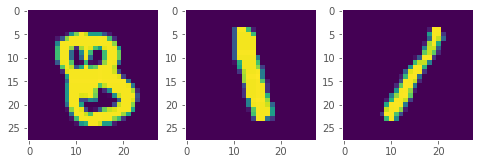

Bag number: 1


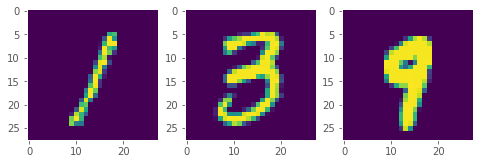

Bag number: 2


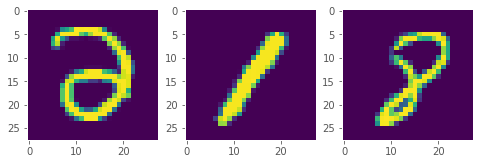

The bag class label is negative
Bag number: 4


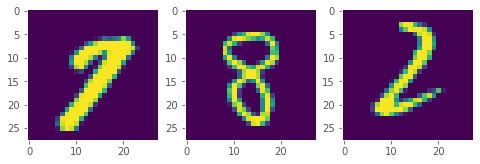

Bag number: 5


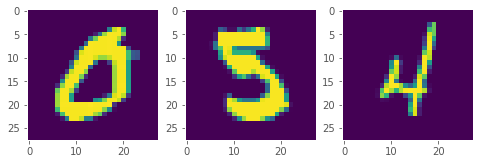

Bag number: 7


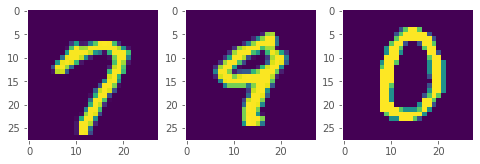

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 28, 28)]     0           []                               
                                                                                                  
 flatten_3 (Flatten)            (None, 784)          0           ['input_4[0][0]']                
                                                                                            

100%|██████████| 1/1 [01:00<00:00, 60.46s/it]


The average loss and accuracy are 0.07 and 98.00 % resp.
The bag class label is positive
Bag number: 0


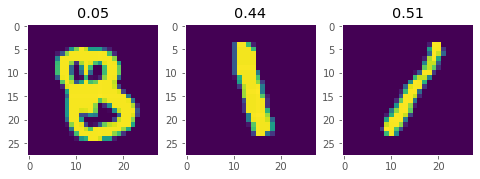

Bag number: 1


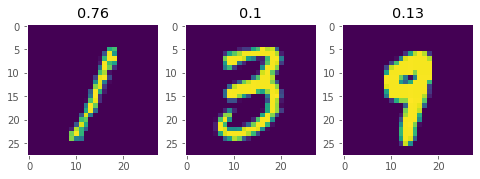

Bag number: 2


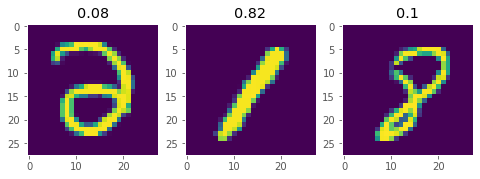

The bag class label is negative
Bag number: 4


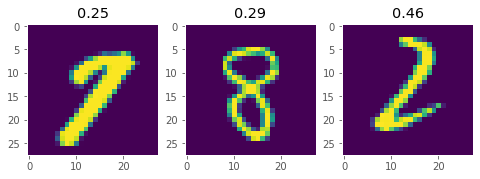

Bag number: 5


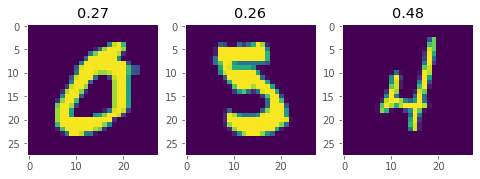

Bag number: 7


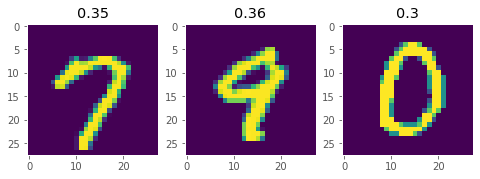

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tqdm import tqdm
from matplotlib import pyplot as plt

plt.style.use("ggplot")

# Configuration Parameters
POSITIVE_CLASS = 1
BAG_COUNT = 1000
VAL_BAG_COUNT = 300
BAG_SIZE = 3
PLOT_SIZE = 3
ENSEMBLE_AVG_COUNT = 1

# Bags preparation
def create_bags(input_data, input_labels, positive_class, bag_count, instance_count):

    # Set up bags.
    bags = []
    bag_labels = []

    # Normalize input data.
    input_data = np.divide(input_data, 255.0)

    # Count positive samples.
    count = 0

    for _ in range(bag_count):

        # Pick a fixed size random subset of samples.
        index = np.random.choice(input_data.shape[0], instance_count, replace=False)
        instances_data = input_data[index]
        instances_labels = input_labels[index]

        # By default, all bags are labeled as 0.
        bag_label = 0

        # Check if there is at least a positive class in the bag.
        if positive_class in instances_labels:

            # Positive bag will be labeled as 1.
            bag_label = 1
            count += 1

        bags.append(instances_data)
        bag_labels.append(np.array([bag_label]))

    print(f"Positive bags: {count}")
    print(f"Negative bags: {bag_count - count}")

    return (list(np.swapaxes(bags, 0, 1)), np.array(bag_labels))


# Load dataset which is available in keras library
# Load the MNIST dataset.
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

# Create training data.
train_data, train_labels = create_bags(
    x_train, y_train, POSITIVE_CLASS, BAG_COUNT, BAG_SIZE
)

# Create validation data.
val_data, val_labels = create_bags(
    x_val, y_val, POSITIVE_CLASS, VAL_BAG_COUNT, BAG_SIZE
)

# Model Creation
class MILAttentionLayer(layers.Layer):
    """Implementation of the attention-based Deep MIL layer.

    Args:
      weight_params_dim: Positive Integer. Dimension of the weight matrix.
      kernel_initializer: Initializer for the `kernel` matrix.
      kernel_regularizer: Regularizer function applied to the `kernel` matrix.
      use_gated: Boolean, whether or not to use the gated mechanism.

    Returns:
      List of 2D tensors with BAG_SIZE length.
      The tensors are the attention scores after softmax with shape `(batch_size, 1)`.
    """

    def __init__(
        self,
        weight_params_dim,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        use_gated=False,
        **kwargs,
    ):

        super().__init__(**kwargs)

        self.weight_params_dim = weight_params_dim
        self.use_gated = use_gated

        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

        self.v_init = self.kernel_initializer
        self.w_init = self.kernel_initializer
        self.u_init = self.kernel_initializer

        self.v_regularizer = self.kernel_regularizer
        self.w_regularizer = self.kernel_regularizer
        self.u_regularizer = self.kernel_regularizer

    def build(self, input_shape):

        # Input shape.
        # List of 2D tensors with shape: (batch_size, input_dim).
        input_dim = input_shape[0][1]

        self.v_weight_params = self.add_weight(
            shape=(input_dim, self.weight_params_dim),
            initializer=self.v_init,
            name="v",
            regularizer=self.v_regularizer,
            trainable=True,
        )

        self.w_weight_params = self.add_weight(
            shape=(self.weight_params_dim, 1),
            initializer=self.w_init,
            name="w",
            regularizer=self.w_regularizer,
            trainable=True,
        )

        if self.use_gated:
            self.u_weight_params = self.add_weight(
                shape=(input_dim, self.weight_params_dim),
                initializer=self.u_init,
                name="u",
                regularizer=self.u_regularizer,
                trainable=True,
            )
        else:
            self.u_weight_params = None

        self.input_built = True

    def call(self, inputs):

        # Assigning variables from the number of inputs.
        instances = [self.compute_attention_scores(instance) for instance in inputs]

        # Apply softmax over instances such that the output summation is equal to 1.
        alpha = tf.math.softmax(instances, axis=0)

        return [alpha[i] for i in range(alpha.shape[0])]

    def compute_attention_scores(self, instance):

        # Reserve in-case "gated mechanism" used.
        original_instance = instance

        # tanh(v*h_k^T)
        instance = tf.math.tanh(tf.tensordot(instance, self.v_weight_params, axes=1))

        # for learning non-linear relations efficiently.
        if self.use_gated:

            instance = instance * tf.math.sigmoid(
                tf.tensordot(original_instance, self.u_weight_params, axes=1)
            )

        # w^T*(tanh(v*h_k^T)) / w^T*(tanh(v*h_k^T)*sigmoid(u*h_k^T))
        return tf.tensordot(instance, self.w_weight_params, axes=1)



# Visualizer tool
def plot(data, labels, bag_class, predictions=None, attention_weights=None):

    """"Utility for plotting bags and attention weights.

    Args:
      data: Input data that contains the bags of instances.
      labels: The associated bag labels of the input data.
      bag_class: String name of the desired bag class.
        The options are: "positive" or "negative".
      predictions: Class labels model predictions.
      If you don't specify anything, ground truth labels will be used.
      attention_weights: Attention weights for each instance within the input data.
      If you don't specify anything, the values won't be displayed.
    """

    labels = np.array(labels).reshape(-1)

    if bag_class == "positive":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

        else:
            labels = np.where(labels == 1)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    elif bag_class == "negative":
        if predictions is not None:
            labels = np.where(predictions.argmax(1) == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]
        else:
            labels = np.where(labels == 0)[0]
            bags = np.array(data)[:, labels[0:PLOT_SIZE]]

    else:
        print(f"There is no class {bag_class}")
        return

    print(f"The bag class label is {bag_class}")
    for i in range(PLOT_SIZE):
        figure = plt.figure(figsize=(8, 8))
        print(f"Bag number: {labels[i]}")
        for j in range(BAG_SIZE):
            image = bags[j][i]
            figure.add_subplot(1, BAG_SIZE, j + 1)
            plt.grid(False)
            if attention_weights is not None:
                plt.title(np.around(attention_weights[labels[i]][j], 2))
            plt.imshow(image)
        plt.show()


# Plot some of validation data bags per class.
plot(val_data, val_labels, "positive")
plot(val_data, val_labels, "negative")


# Model creation
def create_model(instance_shape):

    # Extract features from inputs.
    inputs, embeddings = [], []
    shared_dense_layer_1 = layers.Dense(128, activation="relu")
    shared_dense_layer_2 = layers.Dense(64, activation="relu")
    for _ in range(BAG_SIZE):
        inp = layers.Input(instance_shape)
        flatten = layers.Flatten()(inp)
        dense_1 = shared_dense_layer_1(flatten)
        dense_2 = shared_dense_layer_2(dense_1)
        inputs.append(inp)
        embeddings.append(dense_2)

    # Invoke the attention layer.
    alpha = MILAttentionLayer(
        weight_params_dim=256,
        kernel_regularizer=keras.regularizers.l2(0.01),
        use_gated=True,
        name="alpha",
    )(embeddings)

    # Multiply attention weights with the input layers.
    multiply_layers = [
        layers.multiply([alpha[i], embeddings[i]]) for i in range(len(alpha))
    ]

    # Concatenate layers.
    concat = layers.concatenate(multiply_layers, axis=1)

    # Classification output node.
    output = layers.Dense(2, activation="softmax")(concat)

    return keras.Model(inputs, output)


# Class weight computing
def compute_class_weights(labels):

    # Count number of postive and negative bags.
    negative_count = len(np.where(labels == 0)[0])
    positive_count = len(np.where(labels == 1)[0])
    total_count = negative_count + positive_count

    # Build class weight dictionary.
    return {
        0: (1 / negative_count) * (total_count / 2),
        1: (1 / positive_count) * (total_count / 2),
    }

# Build and train model
def train(train_data, train_labels, val_data, val_labels, model):

    # Train model.
    # Prepare callbacks.
    # Path where to save best weights.

    # Take the file name from the wrapper.
    file_path = "/tmp/best_model_weights.h5"

    # Initialize model checkpoint callback.
    model_checkpoint = keras.callbacks.ModelCheckpoint(
        file_path,
        monitor="val_loss",
        verbose=0,
        mode="min",
        save_best_only=True,
        save_weights_only=True,
    )

    # Initialize early stopping callback.
    # The model performance is monitored across the validation data and stops training
    # when the generalization error cease to decrease.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, mode="min"
    )

    # Compile model.
    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"],
    )

    # Fit model.
    model.fit(
        train_data,
        train_labels,
        validation_data=(val_data, val_labels),
        epochs=20,
        class_weight=compute_class_weights(train_labels),
        batch_size=1,
        callbacks=[early_stopping, model_checkpoint],
        verbose=0,
    )

    # Load best weights.
    model.load_weights(file_path)

    return model


# Building model(s).
instance_shape = train_data[0][0].shape
models = [create_model(instance_shape) for _ in range(ENSEMBLE_AVG_COUNT)]

# Show single model architecture.
print(models[0].summary())

# Training model(s).
trained_models = [
    train(train_data, train_labels, val_data, val_labels, model)
    for model in tqdm(models)
]

# Model evaluation
def predict(data, labels, trained_models):

    # Collect info per model.
    models_predictions = []
    models_attention_weights = []
    models_losses = []
    models_accuracies = []

    for model in trained_models:

        # Predict output classes on data.
        predictions = model.predict(data)
        models_predictions.append(predictions)

        # Create intermediate model to get MIL attention layer weights.
        intermediate_model = keras.Model(model.input, model.get_layer("alpha").output)

        # Predict MIL attention layer weights.
        intermediate_predictions = intermediate_model.predict(data)

        attention_weights = np.squeeze(np.swapaxes(intermediate_predictions, 1, 0))
        models_attention_weights.append(attention_weights)

        loss, accuracy = model.evaluate(data, labels, verbose=0)
        models_losses.append(loss)
        models_accuracies.append(accuracy)

    print(
        f"The average loss and accuracy are {np.sum(models_losses, axis=0) / ENSEMBLE_AVG_COUNT:.2f}"
        f" and {100 * np.sum(models_accuracies, axis=0) / ENSEMBLE_AVG_COUNT:.2f} % resp."
    )

    return (
        np.sum(models_predictions, axis=0) / ENSEMBLE_AVG_COUNT,
        np.sum(models_attention_weights, axis=0) / ENSEMBLE_AVG_COUNT,
    )


# Evaluate and predict classes and attention scores on validation data.
class_predictions, attention_params = predict(val_data, val_labels, trained_models)

# Plot some results from our validation data.
plot(
    val_data,
    val_labels,
    "positive",
    predictions=class_predictions,
    attention_weights=attention_params,
)
plot(
    val_data,
    val_labels,
    "negative",
    predictions=class_predictions,
    attention_weights=attention_params,
)

In [ ]:
# Install tensorflow-addons
!pip install -U tensorflow-addons

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa


# Data preparation
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

# Hyperparameters
weight_decay = 0.0001
batch_size = 128
num_epochs = 50
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size.
patch_size = 8  # Size of the patches to be extracted from the input images.
num_patches = (image_size // patch_size) ** 2  # Size of the data array.
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of blocks.

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

# Build a classification model
def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks.
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor.
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation)
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


# Experiment defining
def run_experiment(model):
    # Create Adam optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping callback.
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


# Use data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


# Patch extraction as a layer - implementation
class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches


# MLP-Mixer module implementation
class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x


# MLP-Mixer - Build, train and evaluate 
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks)
history = run_experiment(mlpmixer_classifier)


# FNet module implementation
class FNetLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(FNetLayer, self).__init__(*args, **kwargs)

        self.ffn = keras.Sequential(
            [
                layers.Dense(units=embedding_dim),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
                layers.Dense(units=embedding_dim),
            ]
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply fourier transformations.
        x = tf.cast(
            tf.signal.fft2d(tf.cast(inputs, dtype=tf.dtypes.complex64)),
            dtype=tf.dtypes.float32,
        )
        # Add skip connection.
        x = x + inputs
        # Apply layer normalization.
        x = self.normalize1(x)
        # Apply Feedfowrad network.
        x_ffn = self.ffn(x)
        # Add skip connection.
        x = x + x_ffn
        # Apply layer normalization.
        return self.normalize2(x)

# FNet module - Build, train and evaluate
fnet_blocks = keras.Sequential(
    [FNetLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.001
fnet_classifier = build_classifier(fnet_blocks, positional_encoding=True)
history = run_experiment(fnet_classifier)

# gMLP module implementation
class gMLPLayer(layers.Layer):
    def __init__(self, num_patches, embedding_dim, dropout_rate, *args, **kwargs):
        super(gMLPLayer, self).__init__(*args, **kwargs)

        self.channel_projection1 = keras.Sequential(
            [
                layers.Dense(units=embedding_dim * 2),
                tfa.layers.GELU(),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.channel_projection2 = layers.Dense(units=embedding_dim)

        self.spatial_projection = layers.Dense(
            units=num_patches, bias_initializer="Ones"
        )

        self.normalize1 = layers.LayerNormalization(epsilon=1e-6)
        self.normalize2 = layers.LayerNormalization(epsilon=1e-6)

    def spatial_gating_unit(self, x):
        # Split x along the channel dimensions.
        # Tensors u and v will in th shape of [batch_size, num_patchs, embedding_dim].
        u, v = tf.split(x, num_or_size_splits=2, axis=2)
        # Apply layer normalization.
        v = self.normalize2(v)
        # Apply spatial projection.
        v_channels = tf.linalg.matrix_transpose(v)
        v_projected = self.spatial_projection(v_channels)
        v_projected = tf.linalg.matrix_transpose(v_projected)
        # Apply element-wise multiplication.
        return u * v_projected

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize1(inputs)
        # Apply the first channel projection. x_projected shape: [batch_size, num_patches, embedding_dim * 2].
        x_projected = self.channel_projection1(x)
        # Apply the spatial gating unit. x_spatial shape: [batch_size, num_patches, embedding_dim].
        x_spatial = self.spatial_gating_unit(x_projected)
        # Apply the second channel projection. x_projected shape: [batch_size, num_patches, embedding_dim].
        x_projected = self.channel_projection2(x_spatial)
        # Add skip connection.
        return x + x_projected

# gMLP module - Build, train and evaluate
gmlp_blocks = keras.Sequential(
    [gMLPLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)]
)
learning_rate = 0.003
gmlp_classifier = build_classifier(gmlp_blocks)
history = run_experiment(gmlp_classifier)


     |████████████████████████████████| 1.1 MB 4.5 MB/s 
169017344/169001437 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)
Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192
Epoch 1/50
352/352 [==============================] - 530s 1s/step - loss: 3.8435 - acc: 0.1143 - top5-acc: 0.3267 - val_loss: 3.4383 - val_acc: 0.1866 - val_top5-acc: 0.4554 - lr: 0.0050
Epoch 2/50
352/352 [==============================] - 520s 1s/step - loss: 3.3451 - acc: 0.1941 - top5-acc: 0.4700 - val_loss: 3.1339 - val_acc: 0.2410 - val_top5-acc: 0.5272 - lr: 0.0050
Epoch 3/50
352/352 [==============================] - 482s 1s/step - loss: 3.1570 - acc: 0.2283 - top5-acc: 0.5221 - val_loss: 2.9744 - val_acc: 0.2678 - val_top5-acc: 0.5770 - lr: 0.0050
Epoch 4/50
352/352 [==============================] - 477s 1s/step - loss: 3.008